In [1]:
import json
import csv
import numpy as np
import seaborn as sns
import pandas as pd
from collections import Counter
from imblearn.over_sampling import SMOTE 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

#Beolvasás

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
df=pd.read_csv("drive/MyDrive/pol_events_predicted.csv")

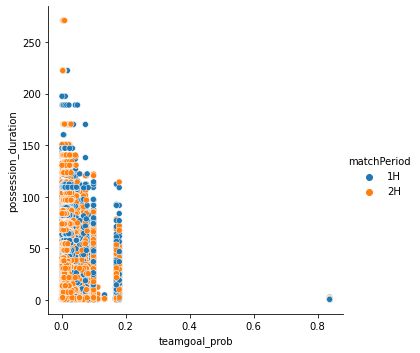

In [4]:
sns.relplot(y='possession_duration', x='teamgoal_prob', hue = 'matchPeriod', data=df)

In [5]:
kept_col = df[['matchPeriod', 'minute', 'second', 'team_id', 'team_name',
               'shot_onTarget','goal','type_primary','type_secondary',
               'MatchName' , 'matchId', 'match_second']]

#Osztályozó rendszer

In [6]:
attacking_value = 70596/193886
kept_col["type_secondary"] = kept_col["type_secondary"].astype('str')
attacking = []
for index, row in kept_col.iterrows():
  if(row['type_primary']=="shot" or row['type_primary']=="penalty" or row['type_secondary'].find("smart_pass") != -1 
     or row['type_secondary'].find("cross") != -1 or row['type_secondary'].find("deep") != -1 or row['type_secondary'].find("dribble") != -1
     or row['type_secondary'].find("foul_suffered") != -1 or row['type_secondary'].find("touch_in_box") != -1
     or row['type_secondary'].find("forward_pass") != -1 or row['type_secondary'].find("opportunity") != -1
     or row['type_secondary'].find("pass_to_penalty_area") != -1 or row['type_secondary'].find("pass_to_final_third") != -1 
     or row['type_secondary'].find("progressive") != -1 or row['type_secondary'].find("through") != -1 ):
    attacking.append(attacking_value)
  elif(row['type_primary']=="own_goal" or row['type_primary']=="clearance" or row['type_secondary'].find("cross") != -1  
       or (row['type_secondary'].find("foul_suffered") == -1 and row['type_secondary'].find("foul") != -1)
        or row['type_secondary'].find("back_pass") != -1 or row['type_secondary'].find("counterpressing_recovery") != -1 
       or row['type_secondary'].find("card") != -1 or row['type_secondary'].find("tackle") != -1
       ):
    attacking.append(-1)
  else:
    attacking.append(0)

kept_col['attacking'] = attacking

kept_col['attacking'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


 0.000000    245539
 0.364111    193886
-1.000000     70596
Name: attacking, dtype: int64

#Származtatott oszlopok, adatmanipuláció

In [7]:
home_team = []
away_team = []
home_score = []
away_score = []


for index, row in kept_col.iterrows():
  element = row.loc['MatchName']
  elements= element.split(" - ")
  home_team.append(elements[0])
  away = elements[1].split(",")
  away_team.append(away[0])
  score = away[1].split("-")
  home_score.append(score[0])
  away_score.append(score[1])


kept_col['home_team'] = home_team
kept_col['away_team'] = away_team
kept_col['home_score'] = home_score
kept_col['away_score'] = away_score

kept_col['home_score'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

 1    177907
 0    124041
 2    121903
 3     52183
 4     28158
 5      5829
Name: home_score, dtype: int64

In [8]:
x = kept_col.groupby(['matchId','team_id'])#['attacking'].sum()

matchIDs = kept_col['matchId'].unique()

len(matchIDs)

matchDFlist = []

for id in matchIDs:
  lista = []
  df = kept_col[kept_col['matchId'] == id]
  teamIDs = df['team_id'].unique()
  for tid in teamIDs:
    team_df = df[df['team_id'] == tid]
    lista.append(team_df)
  matchDFlist.append(lista)
  

print(len(matchIDs))
print(len(matchDFlist))


matchDFlist[2][1].sort_values(by=['team_id'])
print(matchDFlist[16][0].sort_values(by=['team_id',"minute","second"]))

410
410
      matchPeriod  minute  second  team_id      team_name  shot_onTarget  \
19737          1H       0       4    13530  Piast Gliwice            NaN   
19738          1H       0       5    13530  Piast Gliwice            NaN   
19739          1H       0       7    13530  Piast Gliwice            NaN   
19740          1H       0      11    13530  Piast Gliwice            NaN   
19741          1H       0      14    13530  Piast Gliwice            NaN   
...           ...     ...     ...      ...            ...            ...   
21053          2H      92      28    13530  Piast Gliwice            NaN   
21054          2H      92      31    13530  Piast Gliwice            NaN   
21055          2H      92      35    13530  Piast Gliwice            NaN   
21059          2H      92      50    13530  Piast Gliwice            NaN   
21072          2H      93      46    13530  Piast Gliwice            NaN   

        goal  type_primary                                     type_secondary  

In [9]:
isHome= []

for index, row in kept_col.iterrows():
  if(str(row["MatchName"]).startswith(str(row["team_name"]))):
    isHome.append("H")
  else:
    isHome.append("A")
kept_col["match_place"] = isHome
kept_col["match_place"].value_counts()

H    259902
A    250119
Name: match_place, dtype: int64

In [10]:
home_attacking = []
away_attacking= []

for index, row in kept_col.iterrows():
  if(row['match_place']=="H"):
    home_attacking.append(row["attacking"])
    away_attacking.append(0)
  else:
    home_attacking.append(0)
    away_attacking.append(row["attacking"])


kept_col["home_attacking"] = home_attacking
kept_col["away_attacking"]= away_attacking

In [11]:
matchesDfList = []

for id in matchIDs:
  df = kept_col[kept_col['matchId'] == id]
  matchesDfList.append(df)

print(matchesDfList[21])
matchesDfList[1].dtypes
  

      matchPeriod  minute  second  team_id       team_name  shot_onTarget  \
26296          1H       0       5    13518  Pogoń Szczecin            NaN   
26297          1H       0       5    13518  Pogoń Szczecin            NaN   
26298          1H       0       7    13518  Pogoń Szczecin            NaN   
26299          1H       0       9    13518  Pogoń Szczecin            NaN   
26300          1H       0      12    13712       Nieciecza            NaN   
...           ...     ...     ...      ...             ...            ...   
27433          2H      93      23    13712       Nieciecza            NaN   
27434          2H      93      27    13712       Nieciecza            NaN   
27435          2H      93      30    13518  Pogoń Szczecin            NaN   
27436          2H      93      37    13712       Nieciecza            NaN   
27437          2H      93      41    13712       Nieciecza            NaN   

        goal  type_primary                                     type_seconda

matchPeriod        object
minute              int64
second              int64
team_id             int64
team_name          object
shot_onTarget     float64
goal                 bool
type_primary       object
type_secondary     object
MatchName          object
matchId             int64
match_second        int64
attacking         float64
home_team          object
away_team          object
home_score         object
away_score         object
match_place        object
home_attacking    float64
away_attacking    float64
dtype: object

#Moving window kompenzáció nélkül

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

win size: 1  score: 1.21609571759413
win size: 2  score: 1.7576386879145112
win size: 3  score: 2.1724791298255486
win size: 4  score: 2.525622623545953
win size: 5  score: 2.8349514679383403
win size: 6  score: 3.1174123294666245
win size: 7  score: 3.3774917597304475
win size: 8  score: 3.6189416191973818
win size: 9  score: 3.8494929297695135
win size: 10  score: 4.065859574983437
win size: 11  score: 4.275844493037199
win size: 12  score: 4.470508379732669
win size: 13  score: 4.6600396812259595
win size: 14  score: 4.839670675883173
win size: 15  score: 5.015589137168939
win size: 16  score: 5.186730837798063
win size: 17  score: 5.348625411366692
win size: 18  score: 5.5055845685238545
win size: 19  score: 5.661009394613107
win size: 20  score: 5.806766298301643
win size: 21  score: 5.954700615746676
win size: 22  score: 6.0956684897672115
win size: 23  score: 6.235162881841841
win size: 24  score: 6.372629480808311
win size: 25  score: 6.506264518279535
win size: 26  score: 6.63

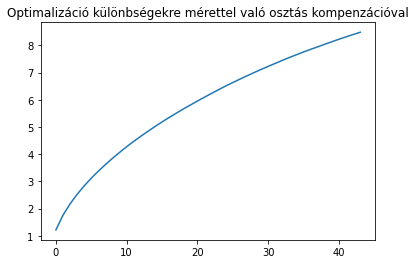

In [13]:
import pandas as pd
import math as math
 
for match in matchesDfList:
  match["min"]=match["minute"]
  match["home_winsum"] = 0
  match["away_winsum"] = 0

min = 1
max = 0
max_win = 0
plotseg=[]

while(min<45):
  avr_diff_list = []
  for match in matchesDfList:
    home_minutes_sums = []
    away_minutes_sums = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sums.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sums.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    home_minutes_sum_ser = pd.Series(home_minutes_sums)
    away_minutes_sum_ser = pd.Series(away_minutes_sums)
    home_windows = pd.DataFrame()
    away_windows = pd.DataFrame()
    home_windows["win"] = home_minutes_sum_ser.rolling(min ,min_periods=1).sum()
    away_windows["win"] = away_minutes_sum_ser.rolling(min ,min_periods=1).sum()
    home_windows_array = home_windows["win"]
    away_windows_array = away_windows["win"]
    for i in range(len(home_windows_array)):
      diffes.append(abs(home_windows_array[i]-away_windows_array[i])) 
    avr_diff_list.append(sum(diffes)/(len(diffes)))
  plotseg.append(sum(avr_diff_list)/len(avr_diff_list))
  print("win size:",min, " score:",sum(avr_diff_list)/len(avr_diff_list))
  if(sum(avr_diff_list)/len(avr_diff_list)>max):
    max = sum(avr_diff_list)/len(avr_diff_list)
    max_win = min
  min+=1
print("----------------------")
print("best win size:", max_win, " score for best win size:", max)
print(max_win)
 
plt.plot(range(len(plotseg)),plotseg)
plt.title("Optimalizáció különbségekre mérettel való osztás kompenzációval")
plt.show()

#Moving window kompenzációval

In [ ]:
import pandas as pd
import math as math
 
for match in matchesDfList:
  match["min"]=match["minute"]
  match["home_winsum"] = 0
  match["away_winsum"] = 0

min = 1
max = 0
max_win = 0
plotseg=[]

while(min<45):
  avr_diff_list = []
  for match in matchesDfList:
    home_minutes_sums = []
    away_minutes_sums = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sums.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sums.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    home_minutes_sum_ser = pd.Series(home_minutes_sums)
    away_minutes_sum_ser = pd.Series(away_minutes_sums)
    home_windows = pd.DataFrame()
    away_windows = pd.DataFrame()
    home_windows["win"] = home_minutes_sum_ser.rolling(min ,min_periods=1).sum()
    away_windows["win"] = away_minutes_sum_ser.rolling(min ,min_periods=1).sum()
    home_windows_array = home_windows["win"]
    away_windows_array = away_windows["win"]
    for i in range(len(home_windows_array)):
      diffes.append(abs(home_windows_array[i]-away_windows_array[i])) 
    avr_diff_list.append(sum(diffes)/(len(diffes)))
  plotseg.append(sum(avr_diff_list)/len(avr_diff_list)/(min))
  print("win size:",min, " score:",sum(avr_diff_list)/len(avr_diff_list)/(min))
  if((sum(avr_diff_list)/len(avr_diff_list)/(min))>max):
    max = sum(avr_diff_list)/len(avr_diff_list)/(min)
    max_win = min
  min+=1
print("----------------------")
print("best win size:", max_win, " score for best win size:", max)
print(max_win)
 
plt.plot(range(len(plotseg)),plotseg)
plt.title("Optimalizáció különbségekre mérettel való osztás kompenzációval")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

win size: 1  score: 1.21609571759413
win size: 2  score: 0.8788193439572556
win size: 3  score: 0.7241597099418495
win size: 4  score: 0.6314056558864882
win size: 5  score: 0.5669902935876681
win size: 6  score: 0.5195687215777708
win size: 7  score: 0.4824988228186354
win size: 8  score: 0.4523677023996727
win size: 9  score: 0.42772143664105705
win size: 10  score: 0.40658595749834375
win size: 11  score: 0.3887131357306544
win size: 12  score: 0.3725423649777224
win size: 13  score: 0.3584645908635353
win size: 14  score: 0.3456907625630838
win size: 15  score: 0.33437260914459593


#ewm logistic regression

In [ ]:
#com
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(com=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(com=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, train_size=0.8, test_size=0.2)
    model= LogisticRegression()
    model.fit(x_train.reshape(-1,1), y_train)
    y_pred=model.predict(x_test.reshape(-1,1))
    scores.append(model.score(x_test.reshape(-1,1),y_test))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#span
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(span=param).mean()
    away_windows = away_minutes_sum_df.ewm(span=param).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, train_size=0.8, test_size=0.2)
    model= LogisticRegression()
    model.fit(x_train.reshape(-1,1), y_train)
    y_pred=model.predict(x_test.reshape(-1,1))
    scores.append(model.score(x_test.reshape(-1,1),y_test))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#halflife
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(halflife=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(halflife=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, train_size=0.8, test_size=0.2)
    model= LogisticRegression()
    model.fit(x_train.reshape(-1,1), y_train)
    y_pred=model.predict(x_test.reshape(-1,1))
    scores.append(model.score(x_test.reshape(-1,1),y_test))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#alpha
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<10):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(alpha=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(alpha=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, train_size=0.8, test_size=0.2)
    model= LogisticRegression()
    model.fit(x_train.reshape(-1,1), y_train)
    y_pred=model.predict(x_test.reshape(-1,1))
    scores.append(model.score(x_test.reshape(-1,1),y_test))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

#ewm Naiv Bayes

In [ ]:
#com
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(com=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(com=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    scores.append((y_test == y_pred).sum()/X_test.shape[0])
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#span
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(span=param).mean()
    away_windows = away_minutes_sum_df.ewm(span=param).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    scores.append((y_test == y_pred).sum()/X_test.shape[0])
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#halflife
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(halflife=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(halflife=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    scores.append((y_test == y_pred).sum()/X_test.shape[0])
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#alpha
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<10):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(alpha=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(alpha=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8, random_state=0)
    gnb = GaussianNB()
    y_pred = gnb.fit(X_train, y_train).predict(X_test)
    scores.append((y_test == y_pred).sum()/X_test.shape[0])
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

#ewm xgboost gólokra

In [ ]:
#com
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from collections import Counter
from imblearn.over_sampling import SMOTE 

params = {
    'max_dept': 9,
    'num_class' : 2,
    'eta': 0.05,
    'gamma': 0.005,
    'learning_rate': 0.5,
    'n-estimators': 50
}
param = 1
f1_max_score = 0
f1_max_param = 0
max_score = 0
max_param = 0
plotseg = []
f1_plotseg = []
while(param<50):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(com=param/10, adjust = False).mean()
    away_windows = away_minutes_sum_df.ewm(com=param/10, adjust = False).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_goal_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  plot_seg_gyujt.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1
  param_seg_gyujt.append(param/10)
  fugg_seg_gyujt.append("com")

print("----------------------------------------------")
print("Best param:", max_param," best score :",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#span
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

params = {
    'max_dept': 7,
    'num_class' : 2,
    'eta': 0.05,
    'gamma': 0.005,
    'learning_rate': 0.5,
    'n-estimators': 50
}
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<50):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(span=1+param/10).mean()
    away_windows = away_minutes_sum_df.ewm(span=1+param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_goal_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = 1+param/10
  plotseg.append(sum(scores)/len(scores))
  plot_seg_gyujt.append(sum(scores)/len(scores))
  print("param:",1+param/10," score:",sum(scores)/len(scores))
  param+=1
  param_seg_gyujt.append(param)
  fugg_seg_gyujt.append("span")

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#halflife
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

params = {
    'max_dept': 7,
    'num_class' : 2,
    'eta': 0.05,
    'gamma': 0.005,
    'learning_rate': 0.5,
    'n-estimators': 50
}
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<50):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(halflife=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(halflife=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_goal_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  plot_seg_gyujt.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1
  param_seg_gyujt.append(param/10)
  fugg_seg_gyujt.append("halflife")

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#alpha
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb

params = {
    'max_dept': 7,
    'num_class' : 2,
    'eta': 0.05,
    'gamma': 0.005,
    'learning_rate': 0.5,
    'n-estimators': 50
}
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<50):
  start = 0
  avr_diff_list = []
  goals = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    goals.append(match.loc[(match["goal"]==True), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(alpha=param/50).mean()
    away_windows = away_minutes_sum_df.ewm(alpha=param/50).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_goal_values = []
  for i in range(len(goals)):
    goal_values = []
    goal_values = [0] * len(all_diffes[i])
    for j in range(len(goals[i])):
      goal_values[goals[i].iloc[j]-1] =  1
    all_goal_values.append(goal_values)

  con_goal_values = np.concatenate((all_goal_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE(random_state=2)
  con_diffes_sm, con_goal_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_goal_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_goal_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    #scores.append(accuracy_score(y_test, predictions))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_goal_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/50
  plotseg.append(sum(scores)/len(scores))
  plot_seg_gyujt.append(sum(scores)/len(scores))
  print("param:",param/50," score:",sum(scores)/len(scores))
  param+=1
  param_seg_gyujt.append(param/100)
  fugg_seg_gyujt.append("alpha")

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

#ewm xgboost lövésekre

In [ ]:
#com
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer


params = {
          'eta': 0.05,
          'gamma': 0.01,
          'learning_rate': 1,
          'max_depth': 8,
          'n-estimators': 50,
          'num_class' : 2,
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["type_primary"]=="shot"), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(com=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(com=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#span
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer


params = {
          'eta': 0.05,
          'gamma': 0.01,
          'learning_rate': 1,
          'max_depth': 8,
          'n-estimators': 50,
          'num_class' : 2,
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["type_primary"]=="shot"), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(span=param).mean()
    away_windows = away_minutes_sum_df.ewm(span=param).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    #scores.append(accuracy_score(y_test, predictions))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#halflife
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer


params = {
          'eta': 0.05,
          'gamma': 0.01,
          'learning_rate': 1,
          'max_depth': 8,
          'n-estimators': 50,
          'num_class' : 2,
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["type_primary"]=="shot"), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(halflife=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(halflife=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    #scores.append(accuracy_score(y_test, predictions))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#alpha
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer


params = {
          'eta': 0.05,
          'gamma': 0.01,
          'learning_rate': 1,
          'max_depth': 8,
          'n-estimators': 50,
          'num_class' : 2,
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<10):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["type_primary"]=="shot"), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(alpha=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(alpha=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    #scores.append(accuracy_score(y_test, predictions))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

#ewm xgboost kaput találó lövésekre

In [ ]:
#com
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer
from matplotlib import pyplot as plt


params = {
          'eta': 0.05,
          'gamma': 0.05,
          'learning_rate': 0.5,
          'max_depth': 9,
          'n-estimators': 50,
          'num_class' : 2
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["shot_onTarget"]==1), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(com=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(com=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#span
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer


params = {
          'eta': 0.05,
          'gamma': 0.05,
          'learning_rate': 0.5,
          'max_depth': 9,
          'n-estimators': 50,
          'num_class' : 2
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["shot_onTarget"]==1), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(span=param).mean()
    away_windows = away_minutes_sum_df.ewm(span=param).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param
  plotseg.append(sum(scores)/len(scores))
  print("param:",param," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#halflife
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer


params = {
          'eta': 0.05,
          'gamma': 0.05,
          'learning_rate': 0.5,
          'max_depth': 9,
          'n-estimators': 50,
          'num_class' : 2
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<20):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["shot_onTarget"]==1), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(halflife=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(halflife=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    #scores.append(accuracy_score(y_test, predictions))
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()

In [ ]:
#alpha
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.preprocessing import MultiLabelBinarizer


params = {
          'eta': 0.05,
          'gamma': 0.05,
          'learning_rate': 0.5,
          'max_depth': 9,
          'n-estimators': 50,
          'num_class' : 2
          }
param = 1
max_score = 0
max_param = 0
plotseg = []
while(param<10):
  start = 0
  avr_diff_list = []
  shots = []
  all_diffes = []
  results = []
  for match in matchesDfList:
    max = 0
    max_min = 0
    home_minutes_sum = []
    away_minutes_sum = []
    home_windows = []
    away_windows = []
    diffes = []
    for i in range(match["minute"].max()):
      home_minutes_sum.append(match.loc[(match["minute"]==i), "home_attacking"].sum())
      away_minutes_sum.append(match.loc[(match["minute"]==i), "away_attacking"].sum())
    shots.append(match.loc[(match["shot_onTarget"]==1), "minute"])
    home_minutes_sum_df = pd.Series(home_minutes_sum)
    away_minutes_sum_df = pd.Series(away_minutes_sum)
    home_windows = home_minutes_sum_df.ewm(alpha=param/10).mean()
    away_windows = away_minutes_sum_df.ewm(alpha=param/10).mean()
    for i in range(len(home_windows)):
      diffes.append(abs(home_windows.iloc[i]-away_windows.iloc[i]))
    all_diffes.append(diffes)
    results.append(match["MatchName"])
  avr_diff_list.append(sum(diffes)/len(diffes))

  all_shot_values = []
  for i in range(len(shots)):
    shot_values = []
    shot_values = [0] * len(all_diffes[i])
    for j in range(len(shots[i])):
      shot_values[shots[i].iloc[j]-1] =  1
    all_shot_values.append(shot_values)

  con_shot_values = np.concatenate((all_shot_values))
  con_diffes = np.concatenate((all_diffes))
  sm = SMOTE()
  con_diffes_sm, con_shot_values_sm = sm.fit_resample(con_diffes.reshape(-1, 1),con_shot_values)

  scores = []
  for i in range(100):
    X_train, X_test, y_train, y_test = train_test_split(con_diffes_sm, con_shot_values_sm, test_size=0.8)
    train = xgb.DMatrix(X_train, label=y_train) 
    test = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, train)
    predictions = model.predict(test)
    X_train2, X_test2, y_train2, y_test2 = train_test_split(con_diffes.reshape(-1, 1), con_shot_values, test_size=0.8)
    train2 = xgb.DMatrix(X_train, label=y_train) 
    test2 = xgb.DMatrix(X_test2, label=y_test2)
    model2 = xgb.train(params, train2)
    predictions2 = model2.predict(test2)
    scores.append(accuracy_score(y_test2, predictions2))
  if(sum(scores)/len(scores)>max_score):
    max_score=sum(scores)/len(scores)
    max_param = param/10
  plotseg.append(sum(scores)/len(scores))
  print("param:",param/10," score:",sum(scores)/len(scores))
  param+=1

print("----------------------------------------------")
print("Best param:", max_param," best score:",max_score)
plt.plot(range(len(plotseg)),plotseg)
plt.show()